<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
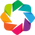

/home/durrieu/miniforge3/envs/tracking_analysis/lib/python3.12/site-packages/starlette/formparsers.py:12: FutureWarning: Please use `import python_multipart` instead.
  import multipart


In [1]:
# from utils_behavior import Sleap_utils
# from utils_behavior import HoloviewsTemplates
# from utils_behavior import HoloviewsPlots
# from utils_behavior import Utils
from utils_behavior import Processing

# from utils_behavior import Ballpushing_utils


import importlib

from pathlib import Path

import json

from matplotlib import pyplot as plt
import pandas as pd
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
import seaborn as sns
from shiny import App, Inputs, Outputs, Session, reactive, render, req, ui



#import lux

import pandas as pd

#lux.config.set_executor_type("Pandas")

import numpy as np
import h5py
import re

In [ ]:
importlib.reload(Ballpushing_utils)

In [ ]:
Datapath = Path("/mnt/upramdya_data/MD/F1_Tracks/Videos")

# Look for video folders and load Fly objects

# videos = list(Datapath.rglob("*.mp4"))

# Flies = []

# for video in videos:
#     fly = Ballpushing_utils.Fly(video.parent)
    
#     Flies.append(fly)

# For each directory in the datapath, load the Experiment object
Experiments = []

for exp in Datapath.iterdir():
    if exp.is_dir():
        experiment = Ballpushing_utils.Experiment(exp, experiment_type="F1")
        Experiments.append(experiment)

In [ ]:
importlib.reload(Ballpushing_utils)

In [ ]:
Data_F1 = Ballpushing_utils.Dataset(Experiments, dataset_type="F1_coordinates" )

str(Data_F1)

In [ ]:
Data_F1_coordinates = Data_F1.data

In [ ]:
# Save dataset as feather

Data_F1_coordinates.to_feather("/mnt/upramdya_data/MD/F1_Tracks/Datasets/F1_coordinates.feather")

In [2]:
# Load dataset from feather
Data_F1_coordinates = pd.read_feather("/mnt/upramdya_data/MD/F1_Tracks/Datasets/F1_coordinates.feather")

In [3]:
Data_F1_coordinates["fly"].nunique()

191

In [4]:
Data_F1_coordinates.head()

,index,time,frame,adjusted_time,training_ball,test_ball,fly,flypath,experiment,Nickname,...,Orientation,Pretraining,Unlocked,,F1_condition,FeedingState,Light,Crossing,Balltype,EndChamber
0,0,0.034483,1,-6929.310345,0.000000,0.000000,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,None,NaN,NaN,NaN,NaN
1,1,0.068966,2,-6929.275862,0.000622,0.004269,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,None,NaN,NaN,NaN,NaN
2,2,0.103448,3,-6929.241379,0.001243,0.008538,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,None,NaN,NaN,NaN,NaN
3,3,0.137931,4,-6929.206897,0.001865,0.012808,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,None,NaN,NaN,NaN,NaN
4,4,0.172414,5,-6929.172414,0.002486,0.017077,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,None,NaN,NaN,NaN,NaN


In [5]:
# Keep only data where adjusted time is >= 0

Data_F1_coordinates = Data_F1_coordinates[Data_F1_coordinates["adjusted_time"] >= 0]

Data_F1_coordinates = Data_F1_coordinates[Data_F1_coordinates["adjusted_time"] <= 2700]

Permutation Test

In [6]:
Data_F1_coordinates['F1_condition'].unique()

array(['pretrained', 'control', 'pretrained_unlocked'], dtype=object)

In [ ]:
Subset = Data_F1_coordinates[Data_F1_coordinates["F1_condition"]!= "pretrained_unlocked"]

In [ ]:
bins = 10

Subset_binned = Processing.preprocess_data(Subset, time_col = "adjusted_time", value_col="test_ball", group_col="F1_condition", bins = bins) 

In [ ]:
permutation_test = Processing.compute_permutation_test(Subset_binned, metric = "avg_test_ball",group_col="F1_condition", control_group="control")

permutation_test

In [7]:
Data_F1_coordinates.head()

,index,time,frame,adjusted_time,training_ball,test_ball,fly,flypath,experiment,Nickname,...,Orientation,Pretraining,Unlocked,,F1_condition,FeedingState,Light,Crossing,Balltype,EndChamber
200950,200950,6929.344828,200951,0.000000,157.425240,1.373145,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,None,NaN,NaN,NaN,NaN
200951,200951,6929.379310,200952,0.034483,157.482660,1.373390,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,None,NaN,NaN,NaN,NaN
200952,200952,6929.413793,200953,0.068966,157.540101,1.373658,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,None,NaN,NaN,NaN,NaN
200953,200953,6929.448276,200954,0.103448,157.597640,1.374032,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,None,NaN,NaN,NaN,NaN
200954,200954,6929.482759,200955,0.137931,157.655053,1.374302,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,None,NaN,NaN,NaN,NaN


In [8]:
# Smooth high frequency noise in the data

Data_F1_coordinates["test_ball_smooth"] = Data_F1_coordinates["test_ball"].rolling(window=10, min_periods=1).mean()

In [ ]:
# Save the dataset to a csv file

Data_F1_coordinates.to_csv("/mnt/upramdya_data/MD/F1_Tracks/Datasets/241128_F1_Dataset.csv")

In [9]:
# Load the dataset from a csv file
Data_F1_coordinates_csv = pd.read_csv("/mnt/upramdya_data/MD/F1_Tracks/Datasets/241128_F1_Dataset.csv")

/tmp/ipykernel_387065/721950674.py:2: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  Data_F1_coordinates_csv = pd.read_csv("/mnt/upramdya_data/MD/F1_Tracks/Datasets/241128_F1_Dataset.csv")


In [ ]:
Data_Avg = Data_F1_coordinates.groupby(["F1_condition", "time"]).mean("test_ball").reset_index()

# Data_Avg["test_ball_smooth"] = Processing.savgol_lowpass_filter(
#     Data_Avg["test_ball"], window_length=221, polyorder=1
# )

Data_Avg


In [10]:
# Identify the time at which adjusted time is 0 for each fly
zero_adjusted_time = Data_F1_coordinates.groupby('fly').apply(lambda df: df.loc[df['adjusted_time'].abs().idxmin(), 'time']).reset_index()
zero_adjusted_time.columns = ['fly', 'zero_time']

# Merge the zero_adjusted_time with the original DataFrame
Data_F1_coordinates = Data_F1_coordinates.merge(zero_adjusted_time, on='fly')

# Shift the time values
Data_F1_coordinates['shifted_time'] = Data_F1_coordinates['time'] - Data_F1_coordinates['zero_time']

/tmp/ipykernel_387065/4110805593.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zero_adjusted_time = Data_F1_coordinates.groupby('fly').apply(lambda df: df.loc[df['adjusted_time'].abs().idxmin(), 'time']).reset_index()


In [11]:
# make a rounded adjusted time column where the time is rounded to the nearest 10 seconds

#Data_F1_coordinates["rounded_adjusted_time"] = Data_F1_coordinates["adjusted_time"].round(-1)

# Round adjusted time values to the nearest 10 seconds
Data_F1_coordinates['rounded_adjusted_time'] = (Data_F1_coordinates['adjusted_time'] / 10).round() * 10

In [ ]:
plot_savepath = ""

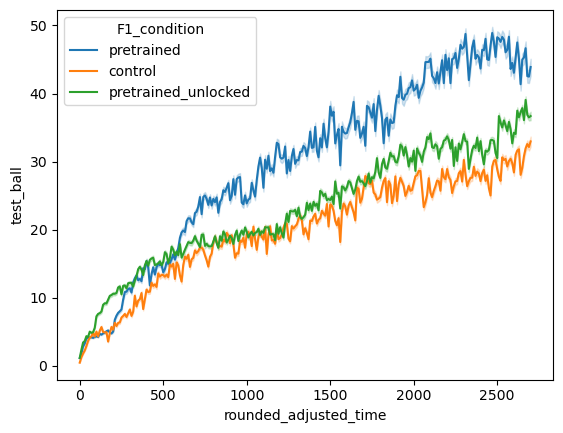

In [12]:
Lineplot = sns.lineplot(data=Data_F1_coordinates, x="rounded_adjusted_time", y="test_ball", hue="F1_condition")

plt.savefig(f"241128_F1_Lineplot.png")

plt.show()

In [ ]:
# Plot the average test ball distance grouped by condition over adjusted time with adjusted time starting at 0

sns.lineplot(data=Data_Avg, x="adjusted_time", y="test_ball_smooth", hue="F1_condition", ci="sd")

# Add the 95% confidence interval

#plt.fill_between(Data_Avg["adjusted_time"], Data_Avg["smoothed_test_ball_upper"], Data_Avg["smoothed_test_ball_lower"], alpha=0.3)

#plt.show()

In [ ]:
# Plot 1: Ball coordinates grouped by Pretraining

Lines_pretraining = sns.lineplot(data=Data_F1_coordinates, x="rounded_adjusted_time", y="test_ball", hue="Pretraining")
plt.title("Ball Coordinates by Pretraining")
plt.xlabel("adjusted time (s)")
plt.ylabel("ball position")
plt.legend(title="Pretraining")
plt.savefig(f"Ball_Coordinates_by_Pretraining.png", bbox_inches="tight")
plt.show()


In [ ]:

# Subset the data to keep only rows where pretraining == "y"
Data_pretrained = Data_F1_coordinates[Data_F1_coordinates["Pretraining"] == "y"]

# Plot 2: Ball coordinates for pretraining == "y", grouped by F1_condition
Lines_unlocking = sns.lineplot(data=Data_pretrained, x="rounded_adjusted_time", y="test_ball", hue="F1_condition",)
plt.title("Ball Coordinates by F1_condition (Pretraining = 'y')")
plt.xlabel("adjusted time (s)")
plt.ylabel("ball position")
plt.legend(title="F1_condition")
plt.savefig(f"Ball_Coordinates_by_F1_condition_Pretraining_Y.png", bbox_inches="tight")
plt.show()

# Exploring the metrics

In [ ]:
importlib.reload(Ballpushing_utils)

In [ ]:
Data_F1_metrics = Ballpushing_utils.Dataset(Experiments, dataset_type="summary" )

str(Data_F1_metrics)

In [ ]:
Data_metrics  = Data_F1_metrics.data

In [ ]:
Data_metrics.head()

In [ ]:
# Save the dataset to a csv file

Data_metrics.to_csv("/mnt/upramdya_data/MD/F1_Tracks/Datasets/241128_F1_Summary.csv")

In [2]:
# Load the dataset from the csv file

Data_metrics = pd.read_csv("/mnt/upramdya_data/MD/F1_Tracks/Datasets/241115_F1_Summary.csv")

In [3]:
Data_metrics

,Unnamed: 0,index,nb_events,max_event,max_event_time,max_distance,final_event,final_event_time,nb_significant_events,significant_ratio,...,Pretraining,Unlocked,Unnamed: 36,F1_condition,ball_condition,FeedingState,Light,Crossing,Balltype,EndChamber
0,0,fly_0_ball_0,3.174903,18.0,7969.586207,189.631525,17.0,7799.965517,0.288628,0.090909,...,y,nn,NaN,pretrained,training,NaN,NaN,NaN,NaN,NaN
1,1,fly_0_ball_1,9.174923,8.0,922.551724,22.370083,NaN,NaN,0.482891,0.052632,...,y,nn,NaN,pretrained,test,NaN,NaN,NaN,NaN,NaN
2,2,fly_0_ball_0,5.777645,49.0,8558.931034,73.194067,NaN,NaN,0.222217,0.038462,...,y,nn,NaN,pretrained,training,NaN,NaN,NaN,NaN,NaN
3,3,fly_0_ball_1,0.000000,NaN,NaN,1.872002,NaN,NaN,0.000000,NaN,...,y,nn,NaN,pretrained,test,NaN,NaN,NaN,NaN,NaN
4,4,fly_0_ball_0,11.666398,34.0,2427.862069,44.008828,NaN,NaN,0.111109,0.009524,...,y,nn,NaN,pretrained,training,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,443,fly_0_ball_0,12.221930,75.0,5200.379310,50.729923,NaN,NaN,0.000000,0.000000,...,y,nn,NaN,pretrained,training,starved,on,NaN,NaN,3mm
444,444,fly_0_ball_1,0.000000,NaN,NaN,1.037281,NaN,NaN,0.000000,NaN,...,y,nn,NaN,pretrained,test,starved,on,NaN,NaN,3mm
445,445,fly_0_ball_0,7.233048,40.0,4789.000000,57.139092,NaN,NaN,0.301377,0.041667,...,n,nn,NaN,control,test,starved_noWater,on,NaN,NaN,3mm
446,446,fly_0_ball_1,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,n,nn,NaN,control,NaN,starved_noWater,on,NaN,NaN,3mm


In [ ]:
Data_metrics.columns

In [4]:
# Plot the pulling ratio for training as x and for test as y, colored by F1 condition

# Data_Training = Data_metrics[(Data_metrics["F1_condition"] != "control") & (Data_metrics["ball_condition"] == "training")]
# Data_Test = Data_metrics[(Data_metrics["F1_condition"] != "control") & (Data_metrics["ball_condition"] == "test")]

Data_Training = Data_metrics[(Data_metrics["ball_condition"] == "training")]
Data_Test = Data_metrics[(Data_metrics["ball_condition"] == "test")]


In [ ]:
Data_Test.columns

In [19]:
# Define the metrics to plot
metrics = [
    'nb_events', 'max_event', 'max_event_time', 'max_distance', 'final_event', 
    'final_event_time', 'nb_significant_events', 'significant_ratio', 
    'first_significant_event', 'first_significant_event_time', 'aha_moment', 
    'major_event',
    'aha_moment_time', 
    'major_event_time','insight_effect', 'cumulated_breaks_duration', 
    'pushed', 'pulled', 'pulling_ratio', 'success_direction', 
    'interaction_proportion', 'distance_moved'
]

# rename "aha_moment" to "major_event" in the Data_Test DataFrame

Data_Test = Data_Test.rename(columns={"aha_moment": "major_event"})
Data_Test = Data_Test.rename(columns={"aha_moment_time": "major_event_time"})

# Set the desired order and update the DataFrame
category_order = ["control",  "pretrained_unlocked",
"pretrained",]
Data_Test["F1_condition"] = pd.Categorical(Data_Test["F1_condition"], categories=category_order, ordered=True)

# Define custom colors
strip_palette = {
    "control": "orange",
    "pretrained": "blue",
    "pretrained_unlocked": "green"
}

# Define a custom color palette for F1_condition
custom_palette = {
    "pretrained": "blue",
    "control": "red",
    "pretrained_unlocked": "green"
}

# Loop through each metric and create the plots
for metric in metrics:
    try:
        plt.figure(figsize=(10, 6))

        # Boxplot: black outline, no fill
        sns.boxplot(
            data=Data_Test,
            x='F1_condition',
            y=metric,
            hue='F1_condition',
            order=category_order,
            hue_order=category_order,
            fliersize=0,
            boxprops=dict(facecolor='none', edgecolor='black'),
            linewidth=2
        )

        # Overlay the stripplot with custom colors
        for i, cond in enumerate(category_order):
            sns.stripplot(
                data=Data_Test[Data_Test["F1_condition"] == cond],
                x='F1_condition',
                y=metric,
                color=strip_palette[cond],
                order=category_order,
                jitter=True,
                size=5,
                alpha=0.7,
                dodge=False
            )

        # Adjust the legend to avoid duplication
        # handles, labels = plt.gca().get_legend_handles_labels()
        # plt.legend(handles[:len(handles)//2], labels[:len(labels)//2], title="F1_condition")
        
        # Remove the legend
        plt.legend([], [], frameon=False)
        plt.xlabel("training condition")

        plt.title(f'{metric.replace("_", " ").capitalize()}')
        plt.savefig(f"F1_plots/{metric}_Test_Ball.eps", bbox_inches="tight")
        plt.savefig(f"F1_plots/{metric}_Test_Ball.png", bbox_inches="tight")
        plt.close()
        
        # Get sample size for each condition for the metric
        sample_sizes = Data_Test.groupby('F1_condition')[metric].count()
        print(f"Sample sizes for {metric}:")
        for cond in category_order:
            print(f"{cond}: {sample_sizes.get(cond, 0)}")
        
    except Exception as e:
        print(f"Error plotting {metric}: {e}")
        continue

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()


Sample sizes for nb_events:
control: 84
pretrained_unlocked: 67
pretrained: 98


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()


Sample sizes for max_event:
control: 76
pretrained_unlocked: 64
pretrained: 45


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()


Sample sizes for max_event_time:
control: 76
pretrained_unlocked: 64
pretrained: 45


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()


Sample sizes for max_distance:
control: 84
pretrained_unlocked: 67
pretrained: 98


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sample sizes for final_event:
control: 15
pretrained_unlocked: 10
pretrained: 12


/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()


Sample sizes for final_event_time:
control: 15
pretrained_unlocked: 10
pretrained: 12


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sample sizes for nb_significant_events:
control: 84
pretrained_unlocked: 67
pretrained: 98


/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sample sizes for significant_ratio:
control: 80
pretrained_unlocked: 66
pretrained: 46


/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sample sizes for first_significant_event:
control: 74
pretrained_unlocked: 55
pretrained: 37


/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sample sizes for first_significant_event_time:
control: 74
pretrained_unlocked: 55
pretrained: 37
Error plotting aha_moment: Could not interpret value `aha_moment` for `y`. An entry with this name does not appear in `data`.


/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sample sizes for major_event:
control: 40
pretrained_unlocked: 27
pretrained: 20
Error plotting aha_moment_time: Could not interpret value `aha_moment_time` for `y`. An entry with this name does not appear in `data`.


/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sample sizes for major_event_time:
control: 40
pretrained_unlocked: 27
pretrained: 20


/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sample sizes for insight_effect:
control: 74
pretrained_unlocked: 55
pretrained: 37


/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()


Sample sizes for cumulated_breaks_duration:
control: 84
pretrained_unlocked: 67
pretrained: 98


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sample sizes for pushed:
control: 84
pretrained_unlocked: 67
pretrained: 98


/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sample sizes for pulled:
control: 84
pretrained_unlocked: 67
pretrained: 98


/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sample sizes for pulling_ratio:
control: 74
pretrained_unlocked: 55
pretrained: 37


/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sample sizes for success_direction:
control: 70
pretrained_unlocked: 52
pretrained: 36


/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sample sizes for interaction_proportion:
control: 84
pretrained_unlocked: 67
pretrained: 98
Sample sizes for distance_moved:
control: 84
pretrained_unlocked: 67
pretrained: 98


/tmp/ipykernel_546316/1085567553.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = Data_Test.groupby('F1_condition')[metric].count()


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [13]:
# Find out how many unique values I have for final_event that are not "Nan", grouped by F1_condition

Data_Test["final_event"].nunique()
Data_Test.groupby("F1_condition")["final_event"].nunique()

/tmp/ipykernel_546316/1452435682.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Data_Test.groupby("F1_condition")["final_event"].nunique()


F1_condition
control                14
pretrained_unlocked     9
pretrained             11
Name: final_event, dtype: int64

In [18]:
# Find out how many unique values I have for final_event that are not "Nan", grouped by F1_condition

#Data_Test["major_event_time"].nunique()
Data_Test.groupby("F1_condition")["major_event"].nunique()

/tmp/ipykernel_546316/3039207874.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Data_Test.groupby("F1_condition")["major_event"].nunique()


F1_condition
control                30
pretrained_unlocked    21
pretrained             15
Name: major_event, dtype: int64

In [44]:
# Define the metrics to process
metrics = [
    'nb_events', 'max_event', 'max_event_time', 'max_distance', 'final_event', 
    'final_event_time', 'nb_significant_events', 'significant_ratio', 
    'first_significant_event', 'first_significant_event_time', 'aha_moment', 
    'aha_moment_time', 'insight_effect', 'cumulated_breaks_duration', 
    'pushed', 'pulled', 'pulling_ratio', 'success_direction', 
    'interaction_proportion', 'distance_moved'
]

# Define a custom color palette for Pretraining
custom_palette = {
    "y": "blue",  # Test
    "n": "red"    # Control
}

# Loop through each metric and create the plots
for metric in metrics:
    try:
        plt.figure(figsize=(10, 6))
        
        # Compute bootstrapped confidence intervals for each Pretraining group
        intervals = {}
        for condition in Data_Test["Pretraining"].unique():
            condition_data = Data_Test[Data_Test["Pretraining"] == condition][metric].dropna()
            if not condition_data.empty:
                intervals[condition] = Processing.draw_bs_ci(
                    data=condition_data.values, func=np.mean, n_reps=300
                )
        
        # Compute effect sizes between conditions (e.g., "y" vs "n")
        if "y" in intervals and "n" in intervals:
            effect_size, effect_size_interval = Processing.compute_effect_size(
                intervals["n"], intervals["y"]
            )
        else:
            effect_size, effect_size_interval = None, None
        
        # Create the stripplot
        sns.stripplot(
            data=Data_Test,
            y='Pretraining',
            x=metric,
            hue='Pretraining',
            #palette=custom_palette,
            dodge=False,
            jitter=True,
            alpha=0.6,
            size=5
        )
        
        # Add bootstrapped confidence intervals as error bars
        for i, condition in enumerate(Data_Test["Pretraining"].unique()):
            if condition in intervals:
                ci = intervals[condition]
                mean_value = Data_Test[Data_Test["Pretraining"] == condition][metric].mean()
                plt.errorbar(
                    y=i, x=mean_value, 
                    xerr=[[mean_value - ci[0]], [ci[1] - mean_value]], 
                    fmt='o', color='black', capsize=5
                )
        
        # Add effect size as text on the plot
        if effect_size is not None:
            plt.text(
                0.8, 0.5, 
                f"Effect Size: {effect_size:.2f}\n95% CI: [{effect_size_interval[0]:.2f}, {effect_size_interval[1]:.2f}]",
                transform=plt.gca().transAxes,
                fontsize=10,
                verticalalignment="center",
                horizontalalignment="center"
            )
        
        # Highlight significant effect sizes
        if effect_size_interval and (effect_size_interval[0] > 0 and effect_size_interval[1] > 0 or
                                    effect_size_interval[0] < 0 and effect_size_interval[1] < 0):
            plt.text(
                0.8, 0.6, "*", 
                transform=plt.gca().transAxes, 
                fontsize=20, color="red", 
                horizontalalignment="center", verticalalignment="center"
            )
        
        # Finalize plot
        plt.title(f"{metric.replace('_', ' ').capitalize()}: Test Ball")
        plt.ylabel("Pretraining")
        plt.xlabel(metric.replace('_', ' ').capitalize())
        plt.legend(title="Pretraining")
        
        # Save the plot
        plt.savefig(f"F1_plots/{metric}_Test_Ball_CI_Pooled_prtr.png", bbox_inches='tight')
        #plt.show()
        plt.close()
        
    except Exception as e:
        print(f"Error processing metric {metric}: {e}")
        continue
    

/tmp/ipykernel_135662/3262393721.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Pretraining")
/tmp/ipykernel_135662/3262393721.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Pretraining")
/tmp/ipykernel_135662/3262393721.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Pretraining")
/tmp/ipykernel_135662/3262393721.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Pretraining")
/tmp/ipykernel_135662/32

Error processing metric success_direction: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


/tmp/ipykernel_135662/3262393721.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Pretraining")
/tmp/ipykernel_135662/3262393721.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Pretraining")


<Figure size 1000x600 with 0 Axes>

In [45]:
# Define the metrics to process
metrics = [
    'nb_events', 'max_event', 'max_event_time', 'max_distance', 'final_event', 
    'final_event_time', 'nb_significant_events', 'significant_ratio', 
    'first_significant_event', 'first_significant_event_time', 'aha_moment', 
    'aha_moment_time', 'insight_effect', 'cumulated_breaks_duration', 
    'pushed', 'pulled', 'pulling_ratio', 'success_direction', 
    'interaction_proportion', 'distance_moved'
]

# Define a custom color palette for F1_condition
custom_palette = {
    "pretrained": "blue",
    "control": "red",
    "pretrained_unlocked": "green"
}

# Loop through each metric and create the plots
for metric in metrics:
    
    try:
        plt.figure(figsize=(10, 6))
        
        # Compute bootstrapped confidence intervals for each F1_condition
        intervals = {}
        for condition in Data_Test["F1_condition"].unique():
            condition_data = Data_Test[Data_Test["F1_condition"] == condition][metric].dropna()
            if not condition_data.empty:
                intervals[condition] = Processing.draw_bs_ci(
                    data=condition_data.values, func=np.mean, n_reps=300
                )
        
        # Compute effect sizes between conditions (e.g., pretrained vs control)
        if "pretrained" in intervals and "control" in intervals:
            effect_size, effect_size_interval = Processing.compute_effect_size(
                intervals["control"], intervals["pretrained"]
            )
        else:
            effect_size, effect_size_interval = None, None
        
        # Create the stripplot
        sns.stripplot(
            data=Data_Test,
            y='F1_condition',
            x=metric,
            hue='F1_condition',
            #palette=custom_palette,
            dodge=False,
            jitter=True,
            alpha=0.6,
            size=5
        )
        
        # Add bootstrapped confidence intervals as error bars
        for i, condition in enumerate(Data_Test["F1_condition"].unique()):
            if condition in intervals:
                ci = intervals[condition]
                mean_value = Data_Test[Data_Test["F1_condition"] == condition][metric].mean()
                plt.errorbar(
                    y=i, x=mean_value, 
                    xerr=[[mean_value - ci[0]], [ci[1] - mean_value]], 
                    fmt='o', color='black', capsize=5
                )
        
        # Add effect size as text on the plot
        if effect_size is not None:
            plt.text(
                0.8, 0.3, 
                f"Effect Size: {effect_size:.2f}\n95% CI: [{effect_size_interval[0]:.2f}, {effect_size_interval[1]:.2f}]",
                transform=plt.gca().transAxes,
                fontsize=10,
                verticalalignment="center",
                horizontalalignment="center"
            )
        
        # Highlight significant effect sizes
        if effect_size_interval[0] > 0 and effect_size_interval[1] > 0 or \
        effect_size_interval[0] < 0 and effect_size_interval[1] < 0:
            plt.text(
                0.8, 0.5, "*", 
                transform=plt.gca().transAxes, 
                fontsize=20, color="red", 
                horizontalalignment="center", verticalalignment="center"
            )
        
        # Finalize plot
        plt.title(f"{metric.replace('_', ' ').capitalize()}: Test Ball")
        plt.ylabel("F1_condition")
        plt.xlabel(metric.replace('_', ' ').capitalize())
        plt.legend(title="F1_condition")
        
        # Save the plot
        plt.savefig(f"F1_plots/{metric}_Test_Ball_CI.png", bbox_inches='tight')
        plt.close()
    
    except Exception as e:
        print(f"Error processing metric {metric}: {e}")
        continue

/tmp/ipykernel_135662/1674875369.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="F1_condition")
/tmp/ipykernel_135662/1674875369.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="F1_condition")
/tmp/ipykernel_135662/1674875369.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="F1_condition")
/tmp/ipykernel_135662/1674875369.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="F1_condition")
/tmp/ipykernel_13566

Error processing metric success_direction: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


/tmp/ipykernel_135662/1674875369.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="F1_condition")
/tmp/ipykernel_135662/1674875369.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="F1_condition")


<Figure size 1000x600 with 0 Axes>

In [ ]:

merged = Data_Training.merge(Data_Test, on="fly")

In [ ]:
merged

In [ ]:
plot_savepath = "/mnt/upramdya_data/MD/F1_Tracks/Plots/250203_NewPlots"

In [ ]:
# Seaborn styling

sns.set_theme(style="whitegrid")

In [ ]:
plt.figure(figsize=(20, 20))
# Create the jointplot
g = sns.jointplot(data=merged, x='pulling_ratio_x', y='pulling_ratio_y', hue='F1_condition_x')

# Set the title and labels using the JointGrid object
g.fig.suptitle('Pulling Ratio: Training vs Test', y=1.03)
g.set_axis_labels('Pulling Ratio (Training)', 'Pulling Ratio (Test)')

# Save the plot before showing it
plt.savefig(f"{plot_savepath}/Pulling_Ratio_Training_vs_Test.png", bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Save the plot
plt.savefig(f"{plot_savepath}/Pulling_Ratio_Training_vs_Test.png")


In [ ]:
Data_Test = Data_metrics[(Data_metrics["ball_condition"] == "test")]

In [ ]:
# Save the dataset to a csv file

Data_Test.to_csv("/mnt/upramdya_data/MD/F1_Tracks/Datasets/241128_F1_Summary_Test.csv")

In [ ]:
# Let's get rid of the flies that never exit the corridor, so for which exit_time is None

Data_metrics = Data_metrics[Data_metrics["exit_time"].notnull()]

In [ ]:
# Make a jitter boxplot of first significant time as function of F1 condition

# Create the figure and axes
plt.figure(figsize=(10, 6))

# Create the boxplot
bp = sns.boxplot(data=Data_Test, x='F1_condition', y='final_event_time', hue='F1_condition')

# Overlay the strip plot
sns.stripplot(data=Data_Test, x='F1_condition', y='final_event_time', color="black", dodge=False, jitter=True, ax=bp)

# Set the title
plt.title('Final Event Time: Test Ball')

# Save the plot with bbox_inches='tight' to avoid cropping
#plt.savefig(f"{plot_savepath}/Final_Event_Time_Test_Ball.png", bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Make a jitter boxplot of first significant time as function of F1 condition

# Create the figure and axes
plt.figure(figsize=(10, 6))

# Create the boxplot
bp = sns.boxplot(data=Data_Test, y='F1_condition', x='max_event_time', color='black', fill=False)

# Overlay the strip plot
sns.stripplot(data=Data_Test, y='F1_condition', x='max_event_time', hue="F1_condition", dodge=False, jitter=True, ax=bp, alpha=0.75)

# Set the title
plt.title('Final Event Time: Test Ball')

# Save the plot with bbox_inches='tight' to avoid cropping
plt.savefig(f"{plot_savepath}/max_event_time_Test_Ball.png", bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
importlib.reload(HoloviewsTemplates)

In [ ]:
# HV version

hv_bp = HoloviewsTemplates.jitter_boxplot(Data_Test, sort_by="F1_condition", metric= 'final_event_time', kdims= 'F1_condition')




hv_bp

In [ ]:
# Here let's compute bootstrap confidence intervals for the mean of the max event time grouped by F1 condition

intervals = {}

for condition in Data_Test["F1_condition"].unique():
    condition_data = Data_Test[Data_Test["F1_condition"] == condition]
    
    BS = Processing.draw_bs_ci(data=condition_data["final_event_time"].dropna(), func=np.mean, n_reps=1000)
    
    intervals[condition] = BS
    

# Compute effect size between pretrained and control BS

effect_size = Processing.compute_effect_size(intervals["control"], intervals["pretrained"])

effect_size


In [ ]:
# Plot the confidence intervals

fig = plt.figure(figsize=(10, 6))

for condition in intervals.keys():
    
    plt.errorbar(x=condition, y=np.mean(intervals[condition]), yerr=np.std(intervals[condition]), fmt='o', label=condition)
    
plt.title('Final event time: Test Ball')

#plt.savefig(f"{plot_savepath}/Final_Event_Time_Test_Ball_CI.png", bbox_inches='tight')

plt.show()

In [ ]:
# Let's now transform these value in h:m:s format

import datetime

average_time = effect_size[0]

print(f"Average time difference between control and pretrained is: {datetime.timedelta(seconds=average_time)}")

interval_times = effect_size[1]

print(f"bootstrapped 95% confidence interval for the difference is: {datetime.timedelta(seconds=interval_times[1])} - {datetime.timedelta(seconds=interval_times[0])}")

In [ ]:
# Make a jitter boxplot of first significant time as function of F1 condition

plt.figure(figsize=(10, 6))
bp = sns.boxplot(data=Data_Test, x='F1_condition', y='max_event_time', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='max_event_time', color = "black", dodge=False, jitter=True)

plt.title('Max event time: Test Ball')

plt.savefig(f"{plot_savepath}/Max_Event_Time_Test_Ball.png", bbox_inches='tight')

plt.show()

In [ ]:
# Here let's compute bootstrap confidence intervals for the mean of the max event time grouped by F1 condition

intervals = {}

for condition in Data_Test["F1_condition"].unique():
    condition_data = Data_Test[Data_Test["F1_condition"] == condition]
    
    BS = Processing.draw_bs_ci(data=condition_data["max_event_time"].dropna(), func=np.mean, n_reps=1000)
    
    intervals[condition] = BS
    
    


In [ ]:
intervals

In [ ]:
# Plot the confidence intervals

fig = plt.figure(figsize=(10, 6))

for condition in intervals.keys():
    
    plt.errorbar(x=condition, y=np.mean(intervals[condition]), yerr=np.std(intervals[condition]), fmt='o', label=condition)
    
plt.title('Max event time: Test Ball')

plt.savefig(f"{plot_savepath}/Max_Event_Time_Test_Ball_CI.png", bbox_inches='tight')

plt.show()

In [ ]:
importlib.reload(Processing)

In [ ]:
# Compute effect size between pretrained and control BS

effect_size = Processing.compute_effect_size(intervals["control"], intervals["pretrained"])

effect_size

In [ ]:
# Let's now transform these value in h:m:s format

import datetime

average_time = effect_size[0]

print(f"Average time difference between control and pretrained is: {datetime.timedelta(seconds=average_time)}")

interval_times = effect_size[1]

print(f"bootstrapped 95% confidence interval for the difference is: {datetime.timedelta(seconds=interval_times[1])} - {datetime.timedelta(seconds=interval_times[0])}")



In [ ]:
Data_Test.columns

In [ ]:
# Make a jitter boxplot of first significant time as function of F1 condition

plt.figure(figsize=(10, 6))
bp = sns.boxplot(data=Data_Test, x='F1_condition', y='aha_moment', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='aha_moment', color = "black", dodge=False, jitter=True)

plt.title('Pulling ratio: Aha moment')

#plt.savefig(f"{plot_savepath}/Aha_Test_Ball.png", bbox_inches='tight')

plt.show()

In [ ]:
# Make a jitter boxplot of first significant time as function of F1 condition

plt.figure(figsize=(10, 6))
bp = sns.boxplot(data=Data_Test, x='F1_condition', y='aha_moment_time', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='aha_moment_time', color = "black", dodge=False, jitter=True)

plt.title('Pulling ratio: Aha moment')

#plt.savefig(f"{plot_savepath}/Aha_Test_Ball_time.png", bbox_inches='tight')

plt.show()

In [ ]:
# Make a jitter boxplot of first significant time as function of F1 condition

plt.figure(figsize=(10, 6))
bp = sns.boxplot(data=Data_Test, y='F1_condition', x='aha_moment_time', color='black', fill=False)
sns.stripplot(data=Data_Test, y='F1_condition', x='aha_moment_time', hue = "F1_condition", dodge=False, jitter=True, alpha=0.75)

plt.title('Pulling ratio: Aha moment')

plt.savefig(f"{plot_savepath}/Aha_Test_Ball_time.png", bbox_inches='tight')

plt.show()

In [ ]:
# Make a jitter boxplot of first significant time as function of F1 condition

plt.figure(figsize=(10, 6))
bp = sns.boxplot(data=Data_Test, x='F1_condition', y='cumulated_breaks_duration', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='cumulated_breaks_duration', color = "black", dodge=False, jitter=True)

#plt.title('Pulling ratio: Aha moment')

#plt.savefig(f"{plot_savepath}/Adjusted_NbEvents.png", bbox_inches='tight')

plt.show()

In [ ]:
# Make a jitter boxplot of first significant time as function of F1 condition

plt.figure(figsize=(10, 6))
bp = sns.boxplot(data=Data_Test, x='F1_condition', y='pulling_ratio', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='pulling_ratio', color = "black", dodge=False, jitter=True)

plt.title('Pulling ratio: Test Ball')

plt.savefig(f"{plot_savepath}/Pulling_Ratio_Test_Ball.png", bbox_inches='tight')

plt.show()

In [ ]:
# Let's make histograms of the pulling ratio for each F1 condition

plt.figure(figsize=(10, 6))

for condition in Data_Test["F1_condition"].unique():
    
    condition_data = Data_Test[Data_Test["F1_condition"] == condition]
    
    sns.histplot(data=condition_data, x='pulling_ratio', kde=True, label=condition)
    
plt.title('Pulling ratio: Test Ball')

plt.show()

In [ ]:
# Now let's make them in 3 different subplots

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, condition in enumerate(Data_Test["F1_condition"].unique()):
    
    condition_data = Data_Test[Data_Test["F1_condition"] == condition]
    
    sns.histplot(data=condition_data, x='pulling_ratio', kde=True, label=condition, ax=axs[i])
    
    axs[i].set_title(condition)
    
plt.suptitle('Pulling ratio: Test Ball')

plt.show()

In [ ]:
# Make a jitter boxplot of first significant time as function of F1 condition

plt.figure(figsize=(10, 6))
sns.boxplot(data=Data_Test, x='F1_condition', y='pulled', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='pulled', color = "black", dodge=False, jitter=True)

plt.title('Pulling events: Test Ball')

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=Data_Test, x='F1_condition', y='pushed', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='pushed', color = "black", dodge=False, jitter=True)

plt.title('Pushing events: Test Ball')


In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=Data_Test, x='F1_condition', y='max_distance', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='max_distance', color = "black", dodge=False, jitter=True)

plt.title('max_distance: Test Ball')

Counter intuitively, the max distance the ball was moved for pretrained is lower

In [ ]:
# Get bootstrap confidence intervals for the mean of the max distance

intervals = {}

for condition in Data_Test["F1_condition"].unique():
    condition_data = Data_Test[Data_Test["F1_condition"] == condition]
    
    BS = Processing.draw_bs_ci(data=condition_data["max_distance"].dropna(), func=np.mean, n_reps=1000)
    
    intervals[condition] = BS

In [ ]:
# Plot the confidence intervals

plt.figure(figsize=(10, 6))

for condition in intervals.keys():
        
        plt.errorbar(x=condition, y=np.mean(intervals[condition]), yerr=np.std(intervals[condition]), fmt='o', label=condition)
        
plt.title('Max distance: Test Ball')

plt.show()

In [ ]:
# Compute effect size between pretrained and control BS

effect_size = Processing.compute_effect_size(intervals["control"], intervals["pretrained"])

effect_size

In [ ]:
# Get how many flies are in each success_direction category, grouped by F1 condition

Data_Test.groupby(["F1_condition", "success_direction"]).size()

Interestingly, there are very little groups that both push and pull the ball significantly. Seems to be one way or the other. 

There could be atleast 2 reasons for that: 

1) The flies have different strategies and stick to them

2) The way the ball looks when it has already been pushed or pulled once is leading to more of the same behavior (some kind of stigmery)

One way to check this is to verify what are the prefered behaviors for the first ball for pretrained

In [ ]:
# For each fly, make a new column that is "match" if the success_direction is the same according for both ball conditions or "different" if it is different

Data_Test.groupby(["F1_condition", "direction_match"]).size()

When only considering strictly different condiditions (ignoring "both" as being push AND pull), I get: 
F1_condition         direction_match
pretrained           different          85
                     match              13
pretrained_unlocked  different          59
                     match               8


If I consider both as partial match, I get: 
F1_condition         direction_match
pretrained           different          44
                     match              13
                     partial_match      41
pretrained_unlocked  different           6
                     match               8
                     partial_match      53


so pretrained have 13 / 98 matches, if counting partial matches as well we get : 54 / 98 (half)
pretrained_unlocked have 8 / 67 match, if counting the partial matches: 61/67

Conclusion: for pretrained_unlocked they probably have much more "both" in the beginning, so that bumps up the partial matches

In [ ]:
# Let's compare success_direction for training and test ball

Data_Training.groupby(["F1_condition", "success_direction"]).size()

Here we have 34 / 96 push, goes up to 76 / 96 if we include both. There's quite a lot of pull as well

In [ ]:
# For pretrained flies, compare fly exit time according to success_direction

plt.figure(figsize=(10, 6))

sns.boxplot(data=Data_Training, x='F1_condition', y='exit_time', hue='success_direction')

As expected, the 20 pull I see for pretrained are the flies that didn't exit (None time) and flies that didn't show pulling (push condition) exited earlier compared to the ones that pulled atleast once. 

> What if we remove the fail flies from the dataset? What will be the consequence?

In [ ]:
Clean_Test = Data_Test.dropna(subset=["exit_time"])

Clean_Test.groupby(["F1_condition", "success_direction"]).size()

In [ ]:
29/51

Now we have for pretrained a majority of pushers, 21 / 36 : 0.58

for pretrained unlocked, same as before as they all exited: 29 /51 : 0.57

Comparable.

In [ ]:
Clean_Test.groupby(["F1_condition", "direction_match"]).size()

Now we get 11/46, with partial match : 34 / 46 : majority are matching.

pretrained unlocked have almost only partial match, didn't change.

In [ ]:
importlib.reload(Ballpushing_utils)

In [ ]:
Data_F1 = Ballpushing_utils.Dataset(Experiments)

In [ ]:
# Generate the checkpoints dataset

Data_Checkpoints = Data_F1.generate_dataset("F1_checkpoints")

In [ ]:
# Get number of unique flies

Data_Checkpoints["fly"].nunique()

In [ ]:
Data_Checkpoints

In [ ]:
# Order the F1_conditions to be pretrained, control, pretrained_unlocked

Data_Checkpoints["F1_condition"] = pd.Categorical(
    Data_Checkpoints["F1_condition"],
    categories=["pretrained", "control", "pretrained_unlocked"],
    ordered=True,
)

In [ ]:
# Save as csv

Data_Checkpoints.to_csv("/mnt/upramdya_data/MD/F1_Tracks/Datasets/241128_F1_Checkpoints.csv")

In [ ]:
#Data_Checkpoints["adjusted_time"] = Data_Checkpoints["adjusted_time"] - Data_Checkpoints["fly_exit_time"]

In [ ]:
# Set the theme and style
sns.set_theme(rc={'figure.figsize':(20,12)})
sns.set_style("whitegrid")

# Create the boxplot with larger boxes
jitterbox = sns.boxplot(x="distance", y="adjusted_time", hue="F1_condition", data=Data_Checkpoints, gap = 0.1, fliersize=0) 

# Overlay the strip plot with jittered points
jitterbox = sns.stripplot(x="distance", y="adjusted_time", hue="F1_condition", color="black", data=Data_Checkpoints, dodge=True, jitter=0.1, size=3)

# Adjust the legend to avoid duplication
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:len(handles)//2], labels[0:len(labels)//2], title="Condition")

# Set the title
jitterbox.set_title("Distance to Checkpoints over Time")

plt.savefig(f"{plot_savepath}/Distance_to_Checkpoints.png", bbox_inches='tight')

plt.show()

In [ ]:
# Create the boxplot with larger boxes
jitterbox = sns.boxplot(x="distance", y="adjusted_time", hue="F1_condition", data=Data_Checkpoints, fliersize=0)

# Add light gray lines for each individual
for name, group in Data_Checkpoints.groupby("fly"):
    plt.plot(group["distance"], group["adjusted_time"], color="lightgray", linewidth=0.5, zorder=0)


# Overlay the strip plot with jittered points
sns.stripplot(x="distance", y="adjusted_time", hue="F1_condition", color="black", data=Data_Checkpoints, dodge=True, jitter=0.1, size=3, ax=jitterbox)

# Adjust the legend to avoid duplication
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:len(handles)//2], labels[0:len(labels)//2], title="Condition")

# Set the title
plt.title("Distance to Checkpoints over Time")

# Save the plot with bbox_inches='tight' to avoid cropping
#plt.savefig(f"{plot_savepath}/Distance_to_Checkpoints.png", bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Now do the same but split it between flies for which Data_Checkpoints["success_direction"] == "push" and Data_Checkpoints["success_direction"] == "pull"

Data_Checkpoints_push = Data_Checkpoints[Data_Checkpoints["success_direction"] == "push"]

Data_Checkpoints_pull = Data_Checkpoints[Data_Checkpoints["success_direction"] == "pull"]

Data_Checkpoints_both = Data_Checkpoints[Data_Checkpoints["success_direction"] == "both"]

# Set the theme and style
sns.set_theme(rc={'figure.figsize':(20,12)})
sns.set_style("whitegrid")

# Create the boxplot with larger boxes

jitterbox = sns.boxplot(x="distance", y="adjusted_time", hue="F1_condition", data=Data_Checkpoints_push, gap = 0.1, fliersize=0)

# Overlay the strip plot with jittered points

jitterbox = sns.stripplot(x="distance", y="adjusted_time", hue="F1_condition", color="black", data=Data_Checkpoints_push, dodge=True, jitter=0.1, size=3)

# Adjust the legend to avoid duplication

handles, labels = plt.gca().get_legend_handles_labels()

plt.legend(handles[0:len(handles)//2], labels[0:len(labels)//2], title="Condition")

# Set the title

jitterbox.set_title("Distance to Checkpoints over Time: Push")

plt.savefig(f"{plot_savepath}/Distance_to_Checkpoints_Push.png", bbox_inches='tight')

plt.show()

In [ ]:



# Set the theme and style
sns.set_theme(rc={'figure.figsize':(20,12)})
sns.set_style("whitegrid")

# Create the boxplot with larger boxes

jitterbox = sns.boxplot(x="distance", y="adjusted_time", hue="F1_condition", data=Data_Checkpoints_pull, gap = 0.1, fliersize=0)

# Overlay the strip plot with jittered points

jitterbox = sns.stripplot(x="distance", y="adjusted_time", hue="F1_condition", color="black", data=Data_Checkpoints_pull, dodge=True, jitter=0.1, size=3)

# Adjust the legend to avoid duplication

handles, labels = plt.gca().get_legend_handles_labels()

plt.legend(handles[0:len(handles)//2], labels[0:len(labels)//2], title="Condition")

# Set the title

jitterbox.set_title("Distance to Checkpoints over Time: Push")

plt.savefig(f"{plot_savepath}/Distance_to_Checkpoints_Pull.png", bbox_inches='tight')

plt.show()

In [ ]:
# Now redo the initial plot but color the points by success direction

# Set the theme and style
sns.set_theme(rc={'figure.figsize':(20,12)})
sns.set_style("whitegrid")

# Define color palettes
boxplot_palette = "Set2"
stripplot_palette = {"push": "blue", "pull": "red", "both": "green", "none": "gray"}

# Create the boxplot with larger boxes
jitterbox = sns.boxplot(x="distance", y="adjusted_time", hue="F1_condition", data=Data_Checkpoints, palette=boxplot_palette, fliersize=0,)

# Overlay the strip plot with jittered points
jitterbox = sns.stripplot(x="distance", y="adjusted_time", hue="F1_condition", color = "red", data=Data_Checkpoints_pull, dodge=True, jitter=0.1, size=3,)

jitterbox = sns.stripplot(x="distance", y="adjusted_time", hue="F1_condition", color = "blue", data=Data_Checkpoints_push, dodge=True, jitter=0.1, size=3,)

jitterbox = sns.stripplot(x="distance", y="adjusted_time", hue="F1_condition", color = "yellow", data=Data_Checkpoints_both, dodge=True, jitter=0.1, size=3,)

# Adjust the legend to avoid duplication
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:len(handles)//2], labels[0:len(labels)//2], title="Success Direction")

# Set the title
jitterbox.set_title("Distance to Checkpoints over Time")

plt.show()

In [ ]:
# Update the 'pretraining' column based on 'F1_condition'
Data_Checkpoints.loc[Data_Checkpoints["F1_condition"] == "pretrained", "pretraining"] = "y"
Data_Checkpoints.loc[Data_Checkpoints["F1_condition"] == "pretrained_unlocked", "pretraining"] = "y"
Data_Checkpoints.loc[Data_Checkpoints["F1_condition"] == "control", "pretraining"] = "n"

# Update the 'unlocked' column based on 'F1_condition'
Data_Checkpoints.loc[Data_Checkpoints["F1_condition"] == "pretrained", "unlocked"] = "n"
Data_Checkpoints.loc[Data_Checkpoints["F1_condition"] == "pretrained_unlocked", "unlocked"] = "y"
Data_Checkpoints.loc[Data_Checkpoints["F1_condition"] == "control", "unlocked"] = "n"

# Display the first few rows of the DataFrame
Data_Checkpoints.head()




In [ ]:
# Save again

Data_Checkpoints.to_csv("/mnt/upramdya_data/MD/F1_Tracks/Datasets/241114_F1_Checkpoints.csv")